In [2]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Texture Synthesis


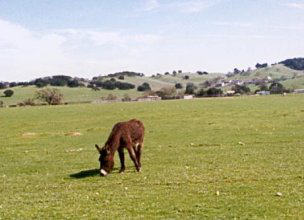

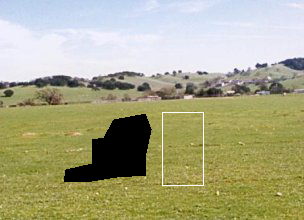

Are you happy with this choice of fillRegion and textureIm?
Number of pixels remaining =  3473
Number of pixels remaining =  1042
Number of pixels remaining =  41


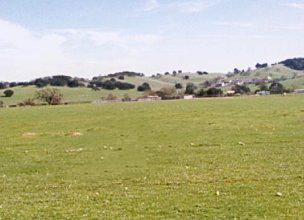

In [7]:
from PIL import Image, ImageDraw
import numpy as np
import random
import os.path
import pickle


def ComputeSSD(TODOPatch, TODOMask, textureIm, patchL):
	patch_rows, patch_cols, patch_bands = np.shape(TODOPatch)
	tex_rows, tex_cols, tex_bands = np.shape(textureIm)
	ssd_rows = tex_rows - 2 * patchL
	ssd_cols = tex_cols - 2 * patchL
	SSD = np.zeros((ssd_rows,ssd_cols))
	for r in range(ssd_rows):
		for c in range(ssd_cols):
    
			# Compute sum square difference between textureIm and TODOPatch
			# for all pixels where TODOMask = 0, and store the result in SSD
			#
			# ADD YOUR CODE HERE
      

			#Centre on each pixel textureIm[r][c](in the dimension of (ssd_rows,ssd_cols)) on the texture image, create a patch sample and loop through each pixel in this patch sample
			for i in range(patch_rows):
				for j in range(patch_cols):

          #Use mask to find those pixels on the TODOPatch that is non-empty(value=0) so that can do the ssd calculation with the sample patch
						if TODOMask[i][j]==0:

            #calculate the corresponding pixel location (of the sample patch)on the texture image
							text_r = r+i
							text_c = c+j
            
            #calculate the ssd between the pixel on the sample patch and pixel on the todoPatch (do all of the 3 color channels)

							ssd_r = (TODOPatch[i][j][0]*1.0-textureIm[text_r][text_c][0]*1.0)**2
							ssd_g = (TODOPatch[i][j][1]*1.0-textureIm[text_r][text_c][1]*1.0)**2
							ssd_b = (TODOPatch[i][j][2]*1.0-textureIm[text_r][text_c][2]*1.0)**2
							SSD[r][c] = SSD[r][c]*1.0+ ssd_r + ssd_g + ssd_b


			pass
		pass
	return SSD

def CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iMatchCenter,jMatchCenter,patchL):
	patchSize = 2 * patchL + 1
	for i in range(patchSize):
		for j in range(patchSize):
			# Copy the selected patch selectPatch into the image containing
			# the hole imHole for each pixel where TODOMask = 1.
			# The patch is centred on iPatchCenter, jPatchCenter in the image imHole
			#
			# ADD YOUR CODE HERE

			# To fill in the empty pixel:
			if TODOMask[i][j]==1: 

        #copy the pixel from the optimized sample patch to fill in the hole on the texture image, copy the color value separately for 3 color channels
				text_r = i+iMatchCenter-patchL
				text_c = j+jMatchCenter-patchL

				patch_r = i+iPatchCenter-patchL
				patch_c = j+jPatchCenter-patchL
        
				imHole[patch_r][patch_c][0] = textureIm[text_r][text_c][0]
				imHole[patch_r][patch_c][1] = textureIm[text_r][text_c][1]
				imHole[patch_r][patch_c][2] = textureIm[text_r][text_c][2]


      #
			pass
		pass
	return imHole

##############################################################################
#                            Some helper functions                           #
##############################################################################

def DrawBox(im,x1,y1,x2,y2):
	draw = ImageDraw.Draw(im)
	draw.line((x1,y1,x1,y2),fill="white",width=1)
	draw.line((x1,y1,x2,y1),fill="white",width=1)
	draw.line((x2,y2,x1,y2),fill="white",width=1)
	draw.line((x2,y2,x2,y1),fill="white",width=1)
	del draw
	return im

def Find_Edge(hole_mask):
	[cols, rows] = np.shape(hole_mask)
	edge_mask = np.zeros(np.shape(hole_mask))
	for y in range(rows):
		for x in range(cols):
			if (hole_mask[x,y] == 1):
				if (hole_mask[x-1,y] == 0 or
						hole_mask[x+1,y] == 0 or
						hole_mask[x,y-1] == 0 or
						hole_mask[x,y+1] == 0):
					edge_mask[x,y] = 1
	return edge_mask

##############################################################################
#                           Main script starts here                          #
##############################################################################

#
# Constants
#

# Change patchL to change the patch size used (patch size is 2 *patchL + 1)
patchL = 10
patchSize = 2*patchL+1

# Standard deviation for random patch selection
randomPatchSD = 1

# Display results interactively
showResults = True

#
# Read input image
#

im = Image.open('/content/drive/MyDrive/cs425/A3/donkey.jpg').convert('RGB')
im_array = np.asarray(im, dtype=np.uint8)
imRows, imCols, imBands = np.shape(im_array)

#
# Define hole and texture regions.  This will use files fill_region.pkl and
#   texture_region.pkl, if both exist, otherwise user has to select the regions.
if os.path.isfile('/content/drive/MyDrive/cs425/A3/fill_region.pkl') and os.path.isfile('/content/drive/MyDrive/cs425/A3/texture_region.pkl'):
	fill_region_file = open('/content/drive/MyDrive/cs425/A3/fill_region.pkl', 'rb')
	fillRegion = pickle.load( fill_region_file )
	fill_region_file.close()

	texture_region_file = open('/content/drive/MyDrive/cs425/A3/texture_region.pkl', 'rb')
	textureRegion = pickle.load( texture_region_file )
	texture_region_file.close()
else:
	# ask the user to define the regions
	print ("Specify the fill and texture regions using polyselect.py")
	exit()

#
# Get coordinates for hole and texture regions
#

fill_indices = fillRegion.nonzero()
nFill = len(fill_indices[0])                # number of pixels to be filled
iFillMax = max(fill_indices[0])
iFillMin = min(fill_indices[0])
jFillMax = max(fill_indices[1])
jFillMin = min(fill_indices[1])
assert((iFillMin >= patchL) and
		(iFillMax < imRows - patchL) and
		(jFillMin >= patchL) and
		(jFillMax < imCols - patchL)) , "Hole is too close to edge of image for this patch size"

texture_indices = textureRegion.nonzero()
iTextureMax = max(texture_indices[0])
iTextureMin = min(texture_indices[0])
jTextureMax = max(texture_indices[1])
jTextureMin = min(texture_indices[1])
textureIm   = im_array[iTextureMin:iTextureMax+1, jTextureMin:jTextureMax+1, :]
texImRows, texImCols, texImBands = np.shape(textureIm)
assert((texImRows > patchSize) and
		(texImCols > patchSize)) , "Texture image is smaller than patch size"

#
# Initialize imHole for texture synthesis (i.e., set fill pixels to 0)
#

imHole = im_array.copy()
imHole[fill_indices] = 0

#
# Is the user happy with fillRegion and textureIm?
#
if showResults == True:
	# original
	im.show()
	display(im)
  
	# convert to a PIL image, show fillRegion and draw a box around textureIm
	im1 = Image.fromarray(imHole).convert('RGB')
	im1 = DrawBox(im1,jTextureMin,iTextureMin,jTextureMax,iTextureMax)
	im1.show()
	display(im1)
	print ("Are you happy with this choice of fillRegion and textureIm?")
	Yes_or_No = False
	while not Yes_or_No:
		answer = input("Yes or No: ")
		if answer == "Yes" or answer == "No":
			Yes_or_No = True
	assert answer == "Yes", "You must be happy. Please try again."

#
# Perform the hole filling
#

while (nFill > 0):
	print ("Number of pixels remaining = " , nFill)

	# Set TODORegion to pixels on the boundary of the current fillRegion
	TODORegion = Find_Edge(fillRegion)
	edge_pixels = TODORegion.nonzero()
	nTODO = len(edge_pixels[0])

	while(nTODO > 0):

		# Pick a random pixel from the TODORegion
		index = np.random.randint(0,nTODO)
		iPatchCenter = edge_pixels[0][index]
		jPatchCenter = edge_pixels[1][index]

		# Define the coordinates for the TODOPatch
		TODOPatch = imHole[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1,:]
		TODOMask = fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1]

		#
		# Compute masked SSD of TODOPatch and textureIm
		#
		ssdIm = ComputeSSD(TODOPatch, TODOMask, textureIm, patchL)

		# Randomized selection of one of the best texture patches
		ssdIm1 = np.sort(np.copy(ssdIm),axis=None)
		ssdValue = ssdIm1[min(round(abs(random.gauss(0,randomPatchSD))),np.size(ssdIm1)-1)]
		ssdIndex = np.nonzero(ssdIm==ssdValue)
		iSelectCenter = ssdIndex[0][0]
		jSelectCenter = ssdIndex[1][0]

		# adjust i, j coordinates relative to textureIm
		iSelectCenter = iSelectCenter + patchL
		jSelectCenter = jSelectCenter + patchL
		selectPatch = textureIm[iSelectCenter-patchL:iSelectCenter+patchL+1,jSelectCenter-patchL:jSelectCenter+patchL+1,:]

		#
		# Copy patch into hole
		#
		imHole = CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iSelectCenter,jSelectCenter,patchL)

		# Update TODORegion and fillRegion by removing locations that overlapped the patch
		TODORegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0
		fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0

		edge_pixels = TODORegion.nonzero()
		nTODO = len(edge_pixels[0])

	fill_indices = fillRegion.nonzero()
	nFill = len(fill_indices[0])

#
# Output results
#
if showResults == True:
	im = Image.fromarray(imHole).convert('RGB')
	im.show()
	display(im)
Image.fromarray(imHole).convert('RGB').save('results.jpg')


###Play with two new images
#### (a) Good result--Sea

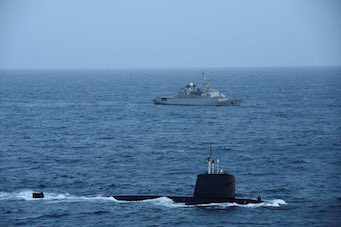

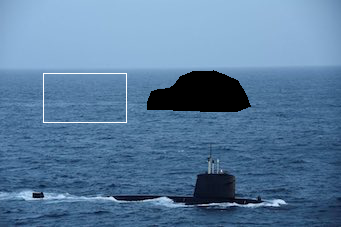

Are you happy with this choice of fillRegion and textureIm?
Yes or No: Yes
Number of pixels remaining =  3168
Number of pixels remaining =  829


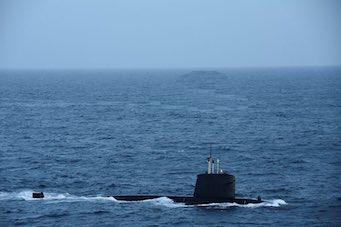

In [20]:
# Change patchL to change the patch size used (patch size is 2 *patchL + 1)
patchL = 10
patchSize = 2*patchL+1

# Standard deviation for random patch selection
randomPatchSD = 0

# Display results interactively
showResults = True

#
# Read input image
#

im = Image.open('/content/drive/MyDrive/cs425/A3/sea.jpg').convert('RGB')
im_array = np.asarray(im, dtype=np.uint8)
imRows, imCols, imBands = np.shape(im_array)

#
# Define hole and texture regions.  This will use files fill_region.pkl and
#   texture_region.pkl, if both exist, otherwise user has to select the regions.
!pip3 install pickle5
import pickle5 as pickle

if os.path.isfile('/content/drive/MyDrive/cs425/A3/sea_fill_region.pkl') and os.path.isfile('/content/drive/MyDrive/cs425/A3/sea_texture_region.pkl'):
	fill_region_file = open('/content/drive/MyDrive/cs425/A3/sea_fill_region.pkl', 'rb')
	fillRegion = pickle.load( fill_region_file )
	fill_region_file.close()

	texture_region_file = open('/content/drive/MyDrive/cs425/A3/sea_texture_region.pkl', 'rb')
	textureRegion = pickle.load( texture_region_file )
	texture_region_file.close()
else:
	# ask the user to define the regions
	print ("Specify the fill and texture regions using polyselect.py")
	exit()

#
# Get coordinates for hole and texture regions
#

fill_indices = fillRegion.nonzero()
nFill = len(fill_indices[0])                # number of pixels to be filled
iFillMax = max(fill_indices[0])
iFillMin = min(fill_indices[0])
jFillMax = max(fill_indices[1])
jFillMin = min(fill_indices[1])
assert((iFillMin >= patchL) and
		(iFillMax < imRows - patchL) and
		(jFillMin >= patchL) and
		(jFillMax < imCols - patchL)) , "Hole is too close to edge of image for this patch size"

texture_indices = textureRegion.nonzero()
iTextureMax = max(texture_indices[0])
iTextureMin = min(texture_indices[0])
jTextureMax = max(texture_indices[1])
jTextureMin = min(texture_indices[1])
textureIm   = im_array[iTextureMin:iTextureMax+1, jTextureMin:jTextureMax+1, :]
texImRows, texImCols, texImBands = np.shape(textureIm)
assert((texImRows > patchSize) and
		(texImCols > patchSize)) , "Texture image is smaller than patch size"

#
# Initialize imHole for texture synthesis (i.e., set fill pixels to 0)
#

imHole = im_array.copy()
imHole[fill_indices] = 0

#
# Is the user happy with fillRegion and textureIm?
#
if showResults == True:
	# original
	im.show()
	display(im)
  
	# convert to a PIL image, show fillRegion and draw a box around textureIm
	im1 = Image.fromarray(imHole).convert('RGB')
	im1 = DrawBox(im1,jTextureMin,iTextureMin,jTextureMax,iTextureMax)
	im1.show()
	display(im1)
	print ("Are you happy with this choice of fillRegion and textureIm?")
	Yes_or_No = False
	while not Yes_or_No:
		answer = input("Yes or No: ")
		if answer == "Yes" or answer == "No":
			Yes_or_No = True
	assert answer == "Yes", "You must be happy. Please try again."

#
# Perform the hole filling
#

while (nFill > 0):
	print ("Number of pixels remaining = " , nFill)

	# Set TODORegion to pixels on the boundary of the current fillRegion
	TODORegion = Find_Edge(fillRegion)
	edge_pixels = TODORegion.nonzero()
	nTODO = len(edge_pixels[0])

	while(nTODO > 0):

		# Pick a random pixel from the TODORegion
		index = np.random.randint(0,nTODO)
		iPatchCenter = edge_pixels[0][index]
		jPatchCenter = edge_pixels[1][index]

		# Define the coordinates for the TODOPatch
		TODOPatch = imHole[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1,:]
		TODOMask = fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1]

		#
		# Compute masked SSD of TODOPatch and textureIm
		#
		ssdIm = ComputeSSD(TODOPatch, TODOMask, textureIm, patchL)

		# Randomized selection of one of the best texture patches
		ssdIm1 = np.sort(np.copy(ssdIm),axis=None)
		ssdValue = ssdIm1[min(round(abs(random.gauss(0,randomPatchSD))),np.size(ssdIm1)-1)]
		ssdIndex = np.nonzero(ssdIm==ssdValue)
		iSelectCenter = ssdIndex[0][0]
		jSelectCenter = ssdIndex[1][0]

		# adjust i, j coordinates relative to textureIm
		iSelectCenter = iSelectCenter + patchL
		jSelectCenter = jSelectCenter + patchL
		selectPatch = textureIm[iSelectCenter-patchL:iSelectCenter+patchL+1,jSelectCenter-patchL:jSelectCenter+patchL+1,:]

		#
		# Copy patch into hole
		#
		imHole = CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iSelectCenter,jSelectCenter,patchL)

		# Update TODORegion and fillRegion by removing locations that overlapped the patch
		TODORegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0
		fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0

		edge_pixels = TODORegion.nonzero()
		nTODO = len(edge_pixels[0])

	fill_indices = fillRegion.nonzero()
	nFill = len(fill_indices[0])

#
# Output results
#
if showResults == True:
	im = Image.fromarray(imHole).convert('RGB')
	im.show()
	display(im)
Image.fromarray(imHole).convert('RGB').save('results_sea.jpg')

####（b) Bad result--mountain

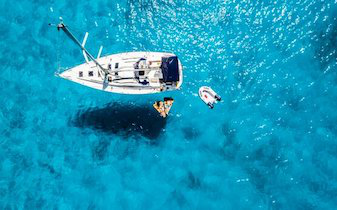

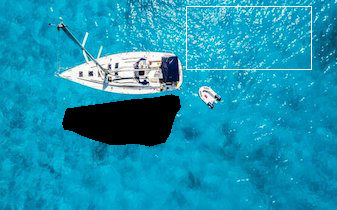

Are you happy with this choice of fillRegion and textureIm?
Yes or No: Yes
Number of pixels remaining =  4420
Number of pixels remaining =  2748
Number of pixels remaining =  1359
Number of pixels remaining =  391


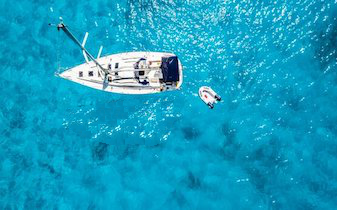

In [19]:
# Change patchL to change the patch size used (patch size is 2 *patchL + 1)
patchL = 3
patchSize = 2*patchL+1

# Standard deviation for random patch selection
randomPatchSD = 10

# Display results interactively
showResults = True

#
# Read input image
#

im = Image.open('/content/drive/MyDrive/cs425/A3/boat.jpg').convert('RGB')
im_array = np.asarray(im, dtype=np.uint8)
imRows, imCols, imBands = np.shape(im_array)

#
# Define hole and texture regions.  This will use files fill_region.pkl and
#   texture_region.pkl, if both exist, otherwise user has to select the regions.
!pip3 install pickle5
import pickle5 as pickle

if os.path.isfile('/content/drive/MyDrive/cs425/A3/bt_fill_region.pkl') and os.path.isfile('/content/drive/MyDrive/cs425/A3/bt_texture_region.pkl'):
	fill_region_file = open('/content/drive/MyDrive/cs425/A3/bt_fill_region.pkl', 'rb')
	fillRegion = pickle.load( fill_region_file )
	fill_region_file.close()

	texture_region_file = open('/content/drive/MyDrive/cs425/A3/bt_texture_region.pkl', 'rb')
	textureRegion = pickle.load( texture_region_file )
	texture_region_file.close()
else:
	# ask the user to define the regions
	print ("Specify the fill and texture regions using polyselect.py")
	exit()

#
# Get coordinates for hole and texture regions
#

fill_indices = fillRegion.nonzero()
nFill = len(fill_indices[0])                # number of pixels to be filled
iFillMax = max(fill_indices[0])
iFillMin = min(fill_indices[0])
jFillMax = max(fill_indices[1])
jFillMin = min(fill_indices[1])
assert((iFillMin >= patchL) and
		(iFillMax < imRows - patchL) and
		(jFillMin >= patchL) and
		(jFillMax < imCols - patchL)) , "Hole is too close to edge of image for this patch size"

texture_indices = textureRegion.nonzero()
iTextureMax = max(texture_indices[0])
iTextureMin = min(texture_indices[0])
jTextureMax = max(texture_indices[1])
jTextureMin = min(texture_indices[1])
textureIm   = im_array[iTextureMin:iTextureMax+1, jTextureMin:jTextureMax+1, :]
texImRows, texImCols, texImBands = np.shape(textureIm)
assert((texImRows > patchSize) and
		(texImCols > patchSize)) , "Texture image is smaller than patch size"

#
# Initialize imHole for texture synthesis (i.e., set fill pixels to 0)
#

imHole = im_array.copy()
imHole[fill_indices] = 0

#
# Is the user happy with fillRegion and textureIm?
#
if showResults == True:
	# original
	im.show()
	display(im)
  
	# convert to a PIL image, show fillRegion and draw a box around textureIm
	im1 = Image.fromarray(imHole).convert('RGB')
	im1 = DrawBox(im1,jTextureMin,iTextureMin,jTextureMax,iTextureMax)
	im1.show()
	display(im1)
	print ("Are you happy with this choice of fillRegion and textureIm?")
	Yes_or_No = False
	while not Yes_or_No:
		answer = input("Yes or No: ")
		if answer == "Yes" or answer == "No":
			Yes_or_No = True
	assert answer == "Yes", "You must be happy. Please try again."

#
# Perform the hole filling
#

while (nFill > 0):
	print ("Number of pixels remaining = " , nFill)

	# Set TODORegion to pixels on the boundary of the current fillRegion
	TODORegion = Find_Edge(fillRegion)
	edge_pixels = TODORegion.nonzero()
	nTODO = len(edge_pixels[0])

	while(nTODO > 0):

		# Pick a random pixel from the TODORegion
		index = np.random.randint(0,nTODO)
		iPatchCenter = edge_pixels[0][index]
		jPatchCenter = edge_pixels[1][index]

		# Define the coordinates for the TODOPatch
		TODOPatch = imHole[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1,:]
		TODOMask = fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1]

		#
		# Compute masked SSD of TODOPatch and textureIm
		#
		ssdIm = ComputeSSD(TODOPatch, TODOMask, textureIm, patchL)

		# Randomized selection of one of the best texture patches
		ssdIm1 = np.sort(np.copy(ssdIm),axis=None)
		ssdValue = ssdIm1[min(round(abs(random.gauss(0,randomPatchSD))),np.size(ssdIm1)-1)]
		ssdIndex = np.nonzero(ssdIm==ssdValue)
		iSelectCenter = ssdIndex[0][0]
		jSelectCenter = ssdIndex[1][0]

		# adjust i, j coordinates relative to textureIm
		iSelectCenter = iSelectCenter + patchL
		jSelectCenter = jSelectCenter + patchL
		selectPatch = textureIm[iSelectCenter-patchL:iSelectCenter+patchL+1,jSelectCenter-patchL:jSelectCenter+patchL+1,:]

		#
		# Copy patch into hole
		#
		imHole = CopyPatch(imHole,TODOMask,textureIm,iPatchCenter,jPatchCenter,iSelectCenter,jSelectCenter,patchL)

		# Update TODORegion and fillRegion by removing locations that overlapped the patch
		TODORegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0
		fillRegion[iPatchCenter-patchL:iPatchCenter+patchL+1,jPatchCenter-patchL:jPatchCenter+patchL+1] = 0

		edge_pixels = TODORegion.nonzero()
		nTODO = len(edge_pixels[0])

	fill_indices = fillRegion.nonzero()
	nFill = len(fill_indices[0])

#
# Output results
#
if showResults == True:
	im = Image.fromarray(imHole).convert('RGB')
	im.show()
	display(im)
Image.fromarray(imHole).convert('RGB').save('results_boat.jpg')

##### Question: Briefly describe why the method failed in the case in which it performed poorly.
Answer:
(1) Set the randomPatchSD too large, then the best texture patches results set will include more sample patches that is not very similar to the neighborhood of the hole, when we do the random selection, will have higher probability to choose these low-precise sample patches to fillin the hole which makes the result perform poorly
(2) Set the patchL too small, which makes the sample patch window size small. When the sample patch get smaller, we will have lesser probability to find the best match since we have lesser information
(3) Also because the texture region I choose does not look simliar to the neighbor of the hole

##Question7.
####Provide an explanation for the effects of the randomPatchSD and patchL parameters. What results can be expected if these values are too small or too large, and why do these results happen?

#####Answer: (1) PatchL: when value too small, we expect to see bad result, while the value getting larger, we are supposed to see better result. Since when we set the patchL too small, this will make the sample patch window size small. When the sample patch get smaller, we will have lesser probability to find the best match since we will have lesser information.
#####(2) randomPatchSD: when value too large, we expect to see bad result, while the value getting smaller(close to 0), we are supposed to see better result. Since when we set the randomPatchSD too large, then the best texture patches results set will include more sample patches that is not very similar to the neighborhood of the hole, when we do the random selection, will have higher probability to choose these low-precise sample patches to fillin the hole which makes the result perform poorly. When we set the value close to zero, will have higher probability to choose the highest-precise sample patche to fillin the hole which makes the result perform better.
